## Análisis de resultados.
En esta hoja de notas queremos comparar los resultados extraidos del DR3 de los obtenidos en el DR2 en el trabajo 
[Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

## Requirements

In [5]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier
from dotenv import load_dotenv
from tqdm import tqdm
from google.cloud import storage

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.utils import read_catalog_file
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_project, ProjectDontExist
from hyper_velocity_stars_detection.tools.stadistics_utils import is_multivariate_normality


load_dotenv("../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../data/hvs-storage.json"
PATH = "../data/globular_clusters"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Resultados Previos
Resultados en el DR2 en el trabajo [Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

In [2]:
v = Vizier(columns=["Name", "Rsun", "e_Rsun", "pmRA*", "e_pmRA*", "pmDE", "e_pmDE", "RV", "e_RV", "rho"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs("J/MNRAS/482/5138")
clusters_dr2 = catalogs[0].to_pandas()
clusters_dr2.Name = clusters_dr2.Name.str.lower()

clusters_dr2["parallax"] = 1 / (clusters_dr2.Rsun)
clusters_dr2["e_parallax"] = (1 / (clusters_dr2.Rsun - clusters_dr2.e_Rsun) - 1 / (clusters_dr2.Rsun + clusters_dr2.e_Rsun)) / 2
clusters_dr2 = clusters_dr2[["Name","parallax", "e_parallax", "pmRA_", "e_pmRA_", "pmDE", "e_pmDE", "RV", "e_RV", "rho", "Rsun", "e_Rsun"]]
clusters_dr2

,Name,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV,rho,Rsun,e_Rsun
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,4.430000,0.04
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,9.980000,0.33
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,9.170000,0.26
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,31.299999,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,15.490000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,10.510000,0.37
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,8.000000,0.57
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,19.000000,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,24.799999,NaN


Extraemos la información de la relación masa luminosidad de los cluster del trabajo [McLaughlin & van der Marel, 2005](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/ApJS/161/304/table13&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa)

In [3]:
catalog2= "J/ApJS/161/304/table13"
catalog1 = "J/ApJS/161/304/clusters"
catalog2= "J/ApJS/161/304/models"

v = Vizier(columns=["**"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs([catalog1, catalog2])
clusters_ml = catalogs[0].to_pandas()
tbl_2 = catalogs[1].to_pandas()

properties = ["Ltot", "Mtot", "M_L"]
for prop in properties:
    df_p = tbl_2[["Cluster", prop, f"e_{prop}", f"E_{prop}"]].sort_values(["Cluster", f"e_{prop}", f"E_{prop}"])
    clusters_ml = pd.merge(clusters_ml, df_p.groupby("Cluster").first().reset_index(), on="Cluster")

clusters_ml.SName = clusters_ml.SName.str.lower()
clusters_ml

,recno,Cluster,RAJ2000,DEJ2000,SB,M,D,SName,logAge,__Fe_H_,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,1,FORNAX1,02 37 02.1,-34 11 00,SB,M,,name fornax 1,10.11,-2.20,...,0.147,4.12,0.03,0.03,4.40,0.05,0.05,1.915,0.163,0.163
1,2,FORNAX2,02 38 40.1,-34 48 05,SB,M,,name fornax 2,10.11,-1.78,...,0.145,4.80,0.04,0.04,5.07,0.05,0.05,1.867,0.156,0.156
2,3,FORNAX3,02 39 52.5,-34 16 08,SB,M,D,name fornax 3,10.11,-1.96,...,0.145,5.13,0.04,0.04,5.40,0.05,0.05,1.880,0.159,0.159
3,4,FORNAX4,02 40 07.9,-34 32 19,SB,M,D,name fornax 4,10.06,-1.90,...,0.076,4.94,0.05,0.05,5.18,0.05,0.05,1.717,0.075,0.075
4,5,FORNAX5,02 42 21.1,-34 06 05,SB,M,D,name fornax 5,10.11,-2.20,...,0.147,4.82,0.04,0.04,5.10,0.05,0.05,1.915,0.163,0.163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,212,SMC-NGC339,00 57 48.9,-74 28 00,SB,M,,ngc 339,9.80,-1.50,...,0.117,4.87,0.05,0.06,4.90,0.07,0.07,1.088,0.104,0.104
149,213,SMC-NGC361,01 02 12.8,-71 36 16,SB,M,,ngc 361,9.91,-1.45,...,0.109,5.18,0.08,0.09,5.30,0.08,0.10,1.313,0.101,0.101
150,214,SMC-NGC411,01 07 56.0,-71 46 05,SB,M,,ngc 411,9.15,-0.68,...,0.038,4.86,0.05,0.05,4.47,0.10,0.10,0.410,0.080,0.080
151,215,SMC-NGC416,01 07 59.0,-72 21 20,SB,M,,ngc 416,9.84,-1.44,...,0.102,5.14,0.04,0.04,5.21,0.05,0.05,1.181,0.084,0.084


In [4]:
df_clusters = pd.merge(clusters_dr2, clusters_ml, left_on=["Name"], right_on="SName", how="left")
df_clusters

,Name,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV,rho,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,...,0.224,5.68,0.01,0.01,6.05,0.04,0.04,2.348,0.239,0.239
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,...,0.186,4.56,0.01,0.01,4.85,0.04,0.04,1.972,0.165,0.165
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,...,0.190,5.23,0.01,0.01,5.53,0.04,0.04,2.013,0.171,0.171
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,...,0.180,4.94,0.00,0.00,5.20,0.04,0.04,1.928,0.158,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,...,0.157,5.57,0.01,0.01,5.84,0.04,0.04,1.872,0.154,0.154
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Resultados DR3

In [18]:
CLUSTER_NAME = "ngc 104"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, project_id = os.getenv("PROJECT_ID"), bucket_name=os.getenv("BUCKET"),path=PATH)
print(str(project))

Las muestras analizadas de ngc 104 son:
Muestras seleccionadas del objeto astronómico ngc 104 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 84612.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 16654.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16654.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 24557.

Muestras seleccionadas del objeto astronómico ngc 104 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 5444.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 1898.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 1898.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 2370.

Se han encontrado 37 fuentes de rayos X.



In [21]:
from zero_point import zpt

data = project.get_data("df_1_c1")
zpt.load_tables() 

In [156]:
data = project.get_data("df_1_c1")
parallax = data['parallax'].values
phot_g_mean_mag = data['phot_g_mean_mag'].values
nueffused = data['nu_eff_used_in_astrometry'].values
pseudocolour = data['pseudocolour'].values
ecl_lat = data['ecl_lat'].values
astrometric_params_solved = data['astrometric_params_solved'].values
zpvals =zpt.get_zpt(phot_g_mean_mag, nueffused, pseudocolour, ecl_lat, astrometric_params_solved)
zpvals

array([-0.030207, -0.041901, -0.030605, ..., -0.029436, -0.03257 ,
       -0.031066], shape=(1654,))

In [157]:
parallax - zpvals

array([0.31602811, 0.85739754, 0.64464352, ..., 0.41390183, 0.38247552,
       0.37042009], shape=(1654,))

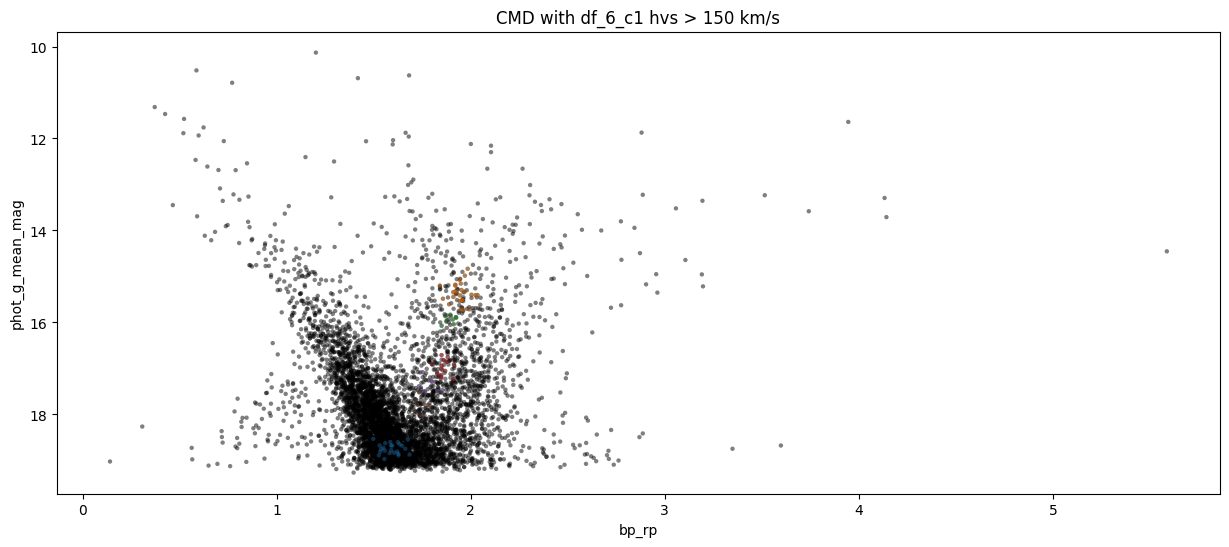

In [158]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False
)

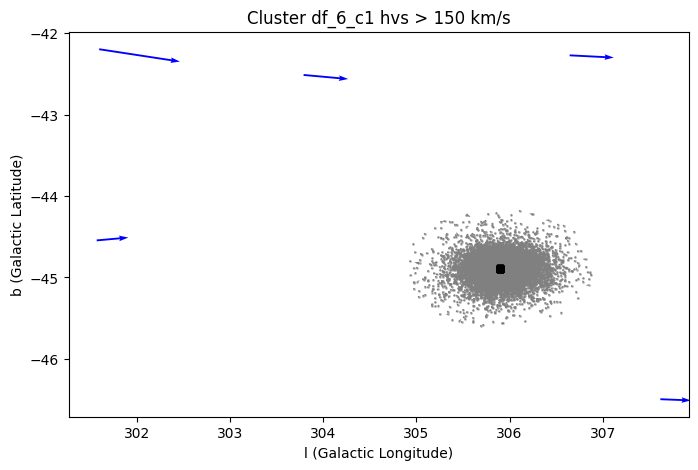

In [25]:
fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            factor_size=50
)

In [27]:
df_hvs_candidates = project.get_data("df_6_c1")
selected = project.clustering_results.selected_hvs(df_hvs_candidates, 1, 150)
selected["pm_kms"] - project.clustering_results.gc.pm_kms.mean()

443     198.316138
589     237.663193
824     159.648235
1541    180.216941
1580    311.599211
Name: pm_kms, dtype: float64

In [29]:
gc = project.clustering_results.gc
parallax = gc['parallax'].values
phot_g_mean_mag = gc['phot_g_mean_mag'].values
nueffused = gc['nu_eff_used_in_astrometry'].values
pseudocolour = gc['pseudocolour'].values
ecl_lat = gc['ecl_lat'].values
astrometric_params_solved = gc['astrometric_params_solved'].values
zpvals =zpt.get_zpt(phot_g_mean_mag, nueffused, pseudocolour, ecl_lat, astrometric_params_solved)
gc["parallax_corrected"] = parallax - zpvals
display(gc[["pmra", "pmdec", "parallax","parallax_corrected"]].describe())

/tmp/ipykernel_6050/1425593126.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gc["parallax_corrected"] = parallax - zpvals


,pmra,pmdec,parallax,parallax_corrected
count,12797.000000,12797.000000,12797.000000,12797.000000
mean,5.251557,-2.574233,0.195411,0.225186
std,0.374576,0.384599,0.077816,0.077615
min,3.059615,-4.270577,-0.227476,-0.197531
25%,5.006763,-2.840394,0.153701,0.183724
50%,5.249858,-2.579028,0.195637,0.226188
75%,5.493504,-2.306996,0.235677,0.264678
max,7.347773,-0.871430,0.564312,0.592316


In [28]:
gc = project.clustering_results.gc
display(gc[["pmra", "pmdec", "parallax","pmra_kms", "pmdec_kms", "radial_velocity"]].describe())

,pmra,pmdec,parallax,pmra_kms,pmdec_kms,radial_velocity
count,12797.000000,12797.000000,12797.000000,1.279700e+04,1.279700e+04,1125.000000
mean,5.251557,-2.574233,0.195411,-4.464373e+01,2.204548e+01,-17.202012
std,0.374576,0.384599,0.077816,2.152303e+04,1.079181e+04,10.794205
min,3.059615,-4.270577,-0.227476,-2.425692e+06,-6.899552e+04,-119.478880
25%,5.006763,-2.840394,0.153701,1.032943e+02,-7.913944e+01,-22.466637
50%,5.249858,-2.579028,0.195637,1.258702e+02,-6.180249e+01,-17.118820
75%,5.493504,-2.306996,0.235677,1.600447e+02,-4.942705e+01,-12.428101
max,7.347773,-0.871430,0.564312,1.239166e+05,1.217126e+06,98.392784


### Reclustering

In [40]:
from sklearn.preprocessing import StandardScaler

data_name = "df_1_c2"

if project.get_data(data_name).shape[0] < 16000:
    data_name = "df_1_c0"

columns_to_clus=["ra", "dec", "pmra", "pmdec", "parallax_corrected"]
columns=["pmra", "pmdec", "parallax_corrected"]

print("Datos seleccionados: %s" %data_name)

clustering = project.cluster_detection(
    data_name=data_name,
    columns=columns, 
    columns_to_clus=columns_to_clus,
    max_cluster=10,
    method="gaussian_mixture",
    noise_method="isolation_forest_method",
    n_trials=100
)

[I 2025-05-25 01:38:19,938] A new study created in memory with name: no-name-d7a7f895-27b6-4865-a4e6-82e42861eb60


Datos seleccionados: df_1_c2


[I 2025-05-25 01:38:20,420] Trial 0 finished with value: 0.7903854488251929 and parameters: {'n_components': 7, 'covariance_type': 'diag', 'tol': 0.00027713397197030225, 'max_iter': 105}. Best is trial 0 with value: 0.7903854488251929.
[I 2025-05-25 01:38:20,922] Trial 1 finished with value: 0.8510850321438296 and parameters: {'n_components': 9, 'covariance_type': 'spherical', 'tol': 3.7951039323742114e-05, 'max_iter': 122}. Best is trial 0 with value: 0.7903854488251929.
[I 2025-05-25 01:38:21,257] Trial 2 finished with value: 0.6505997081034678 and parameters: {'n_components': 5, 'covariance_type': 'diag', 'tol': 0.0006477769898342728, 'max_iter': 183}. Best is trial 2 with value: 0.6505997081034678.
[I 2025-05-25 01:38:21,582] Trial 3 finished with value: 0.8267681348348379 and parameters: {'n_components': 3, 'covariance_type': 'diag', 'tol': 0.000160485673896781, 'max_iter': 154}. Best is trial 2 with value: 0.6505997081034678.
[I 2025-05-25 01:38:21,919] Trial 4 finished with valu

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [42]:
clustering.clustering.noise_method

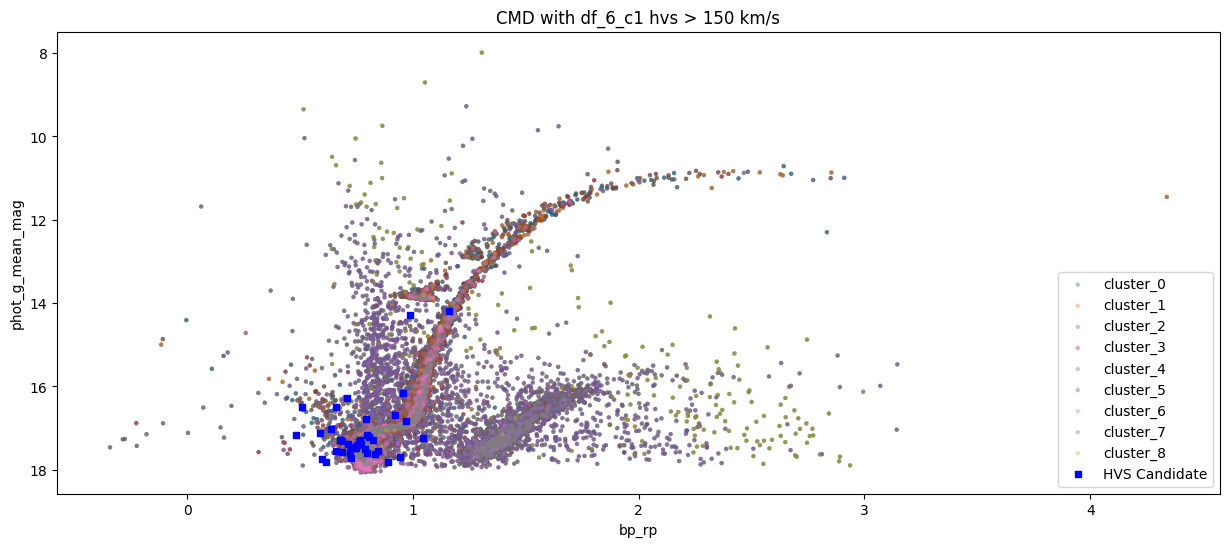

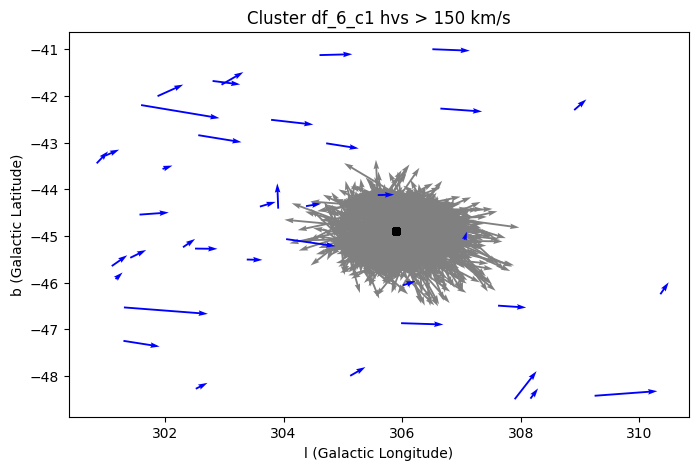

In [34]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=True,
            clusters=None
)

fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            factor_size=50
)

In [198]:
project.clustering_results.get_labels(return_counts=True)

(array([0, 1]), array([449, 383]))

In [199]:
project.clustering_results.main_label

0

In [219]:
project.clustering_results.set_main_label(1)
gc = project.clustering_results.gc
display(gc[["pmra", "pmdec", "parallax_corrected", "radial_velocity"]].describe())

,pmra,pmdec,parallax_corrected,radial_velocity
count,383.000000,383.000000,383.000000,18.000000
mean,-5.335925,-1.687897,0.137530,135.725055
std,0.318288,0.290626,0.171868,7.286962
min,-6.665460,-2.952416,-0.368611,125.230160
25%,-5.466017,-1.803859,0.048601,131.351810
50%,-5.335797,-1.659648,0.132507,134.983260
75%,-5.175670,-1.535223,0.244866,139.642192
max,-3.926354,-0.861084,0.562496,149.011670


In [137]:
project.save_project(to_zip=True)

client = storage.Client(project=os.getenv("PROJECT_ID"))
bucket = client.bucket(os.getenv("BUCKET"))
blob_path = project.astro_object.name+".zip"
path_zip = os.path.join(project.path, blob_path)

blob = bucket.blob(blob_path)
blob.upload_from_filename(path_zip)

In [169]:
gc = project.clustering_results.gc
gc

,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,pmra_kms,pmdec_kms,pm_kms,pm_l,pm_b,uwe,parallax_corrected
1001,1636148068921376768,Gaia DR3 5889480506022883072,5889480506022883072,260888290,2016.0,233.962483,0.190277,-50.676717,0.152289,0.079013,...,NaN,NaN,NaN,-320.686964,-93.412417,334.014983,-5.519052,0.701082,1.046436,0.098583
1462,1636148068921376768,Gaia DR3 5889481498152007808,5889481498152007808,945854046,2016.0,233.894528,0.088074,-50.714211,0.076667,0.199664,...,0.7146,0.7602,MARCS,-126.114248,-44.774525,133.826610,-5.619480,0.386374,1.030332,0.225932
1469,1636148068921376768,Gaia DR3 5889481502455239552,5889481502455239552,1085040349,2016.0,233.885622,0.207612,-50.707696,0.175306,0.038465,...,NaN,NaN,NaN,-633.539110,-207.146572,666.544452,-5.380971,0.506156,1.079188,0.056130
1521,1636148068921376768,Gaia DR3 5889481601221785984,5889481601221785984,1582683425,2016.0,233.812336,0.056694,-50.721775,0.048571,0.127004,...,1.2722,1.3251,PHOENIX,-199.055835,-59.728367,207.823731,-5.525142,0.656623,0.918126,0.157782
1526,1636148068921376768,Gaia DR3 5889481601227796992,5889481601227796992,448610845,2016.0,233.820258,0.089245,-50.714547,0.075245,0.052316,...,0.7386,0.7971,MARCS,-499.832159,-132.482095,517.091571,-5.638044,0.856161,1.070971,0.079350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,1636148068921376768,Gaia DR3 5889483735838874880,5889483735838874880,57716605,2016.0,233.926895,0.064335,-50.636325,0.051881,0.098304,...,1.0672,1.1103,PHOENIX,-247.875650,-87.119813,262.739795,-5.430703,0.390695,1.055110,0.128485
3303,1636148068921376768,Gaia DR3 5889483735886097408,5889483735886097408,193851095,2016.0,233.910338,0.171559,-50.638166,0.131270,0.334930,...,0.0031,0.0255,PHOENIX,-75.933816,-28.054754,80.950686,-5.706553,0.319275,1.041852,0.362152
3713,1636148068921376768,Gaia DR3 5889484560472928384,5889484560472928384,528056514,2016.0,233.888112,0.120675,-50.618538,0.089879,0.157529,...,0.0007,0.0079,PHOENIX,-159.671013,-51.593712,167.799712,-5.545889,0.541118,1.021690,0.183016
3726,1636148068921376768,Gaia DR3 5889484560519874176,5889484560519874176,750125394,2016.0,233.889821,0.019563,-50.616143,0.017209,0.083702,...,NaN,NaN,NaN,-304.650995,-95.762924,319.347407,-5.603613,0.591918,1.003607,0.127218


In [172]:
data.shape[0]

383

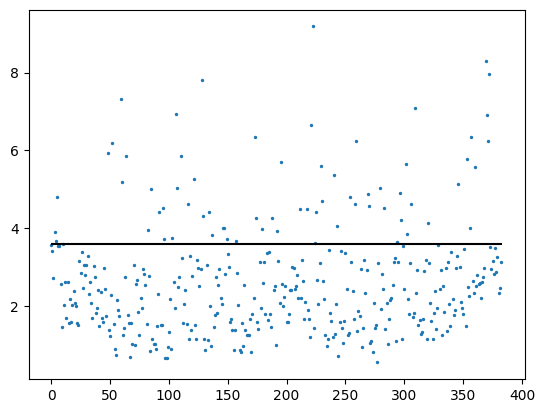

In [220]:
from sklearn.metrics import pairwise_distances
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

data = StandardScaler().fit_transform(gc[columns_to_clus])
cov = MinCovDet(random_state=0).fit(data)


mu = cov.location_
s = cov.covariance_
sinv = np.linalg.inv(s)


dm = pairwise_distances(data, mu.reshape(1,-1), metric="mahalanobis", VI=sinv)

fig, ax = plt.subplots(1,1)
cutoff = np.sqrt(chi2.ppf(0.975, df=data.shape[1]))

ax.scatter(np.arange(data.shape[0]), dm, s=2)
ax.hlines(cutoff, 0, dm.size, color="k")

In [230]:
from sklearn.ensemble import IsolationForest

if_model = IsolationForest()
labels = if_model.fit_predict(gc[columns_to_clus])

In [242]:
from scipy.stats import shapiro

gc[columns_to_clus].apply(lambda x: shapiro(x))

,ra,dec,pmra,pmdec,parallax_corrected
0,0.992586,0.986857,9.331541e-01,9.437615e-01,0.983926
1,0.054586,0.001530,4.430513e-12,7.107507e-11,0.000291


(array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         3.986e+03, 1.358e+03, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         3.941e+03, 1.403e+03, 0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.200e+01,
         4.624e+03, 7.050e+02, 0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.200e+01,
         4.701e+03, 6.160e+02, 2.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         4.583e+03, 7.450e+02, 1.400e+01, 2.000e+00]]),
 array([-35.22736387, -30.08865161, -24.94993935, -19.81122708,
        -14.67251482,  -9.53380256,  -4.39509029,   0.74362197,
          5.88233423,  11.0210465 ,  16.15975876]),
 <a list of 5 BarContainer objects>)

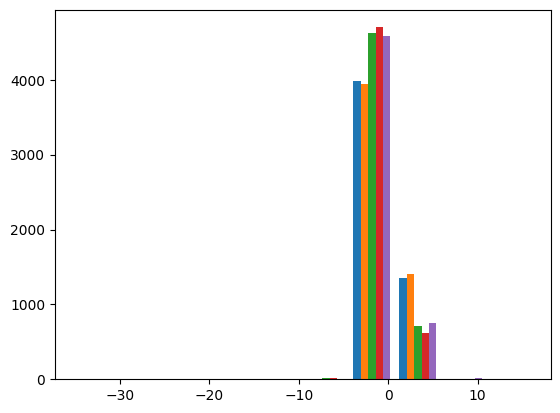

In [227]:
data_star[columns_to_clus].hist()

In [236]:
gc.loc[dm[:,0] <= cutoff, columns].describe()

,pmra,pmdec,parallax_corrected
count,315.000000,315.000000,315.000000
mean,-5.324308,-1.647525,0.130869
std,0.191324,0.179620,0.146306
min,-5.834781,-2.176810,-0.276135
25%,-5.437734,-1.744291,0.055935
50%,-5.334331,-1.651387,0.128485
75%,-5.203191,-1.551794,0.211997
max,-4.813859,-1.157888,0.557928


In [240]:
gc.loc[labels==1, columns].describe()

,pmra,pmdec,parallax_corrected
count,332.000000,332.000000,332.000000
mean,-5.324244,-1.666369,0.132237
std,0.223837,0.220102,0.152343
min,-6.016588,-2.436940,-0.288510
25%,-5.444455,-1.765689,0.053155
50%,-5.334947,-1.654959,0.128849
75%,-5.200457,-1.548128,0.219551
max,-4.298667,-1.080572,0.557928


In [237]:
gc.loc[:, columns].describe()

,pmra,pmdec,parallax_corrected
count,383.000000,383.000000,383.000000
mean,-5.335925,-1.687897,0.137530
std,0.318288,0.290626,0.171868
min,-6.665460,-2.952416,-0.368611
25%,-5.466017,-1.803859,0.048601
50%,-5.335797,-1.659648,0.132507
75%,-5.175670,-1.535223,0.244866
max,-3.926354,-0.861084,0.562496


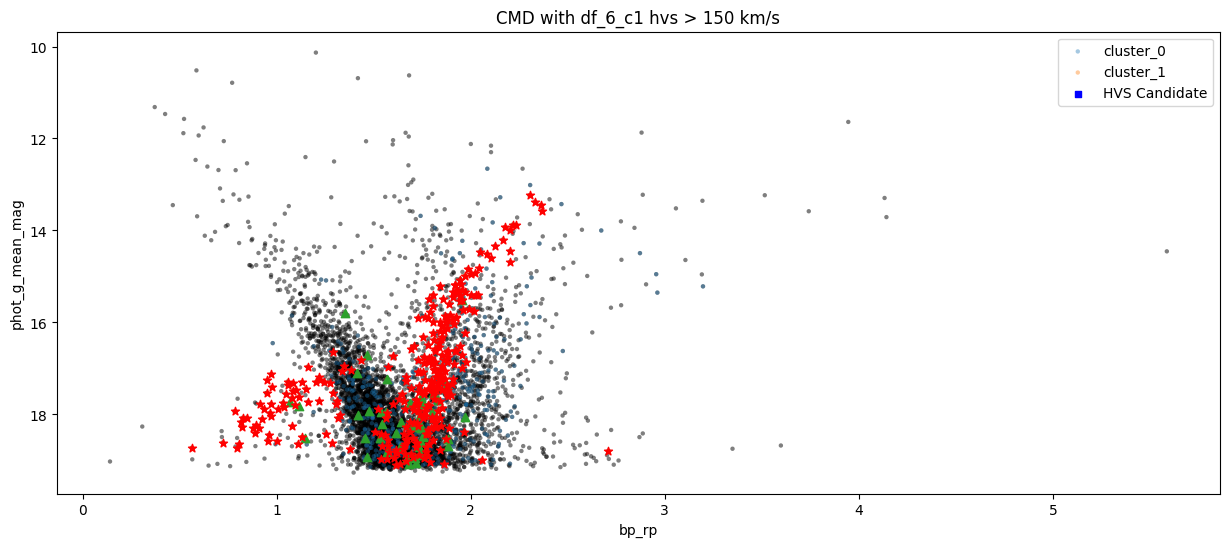

In [235]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 0,
            hvs_pm = 150,
            legend=True,
            clusters=None
)
if_model = IsolationForest()
labels = if_model.fit_predict(gc[columns_to_clus])

gc_selected = gc.loc[dm[:,0] <= cutoff, :]
gc_not_selected = gc.loc[dm[:,0] > cutoff, :]

gc_selected = gc.loc[labels==1, :]
gc_not_selected = gc.loc[labels==-1, :]

ax.scatter(gc_not_selected["bp_rp"], gc_not_selected["phot_g_mean_mag"], marker="^")
ax.scatter(gc_selected["bp_rp"], gc_selected["phot_g_mean_mag"], marker="*", color="r")